In [ ]:
#https://askubuntu.com/questions/742782/how-to-install-cpickle-on-python-3-4
#!conda install -c conda-forge gensim
#!conda install --yes -c conda-forge pyldavis 

In [476]:
import os
import codecs
import json
import spacy
import pandas as pd
import itertools as it
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings
#import cPickle as pickle
import _pickle as pickle
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from IPython.display import Image


In [90]:
nlp = spacy.load('en')


In [10]:
in_dir="./input"
out_dir="./output"

# Filter  contexts to those that have questions

In [11]:
input_json=in_dir+'/wiki_squad_00.json'


In [12]:
with open(input_json) as json_file:  
    input_dict=json.load(json_file)


In [50]:
dict_qid_context=dict.fromkeys(['title','qid','context_raw'], [])


In [51]:
dict_qid_context

{'title': [], 'qid': [], 'context_raw': []}

In [65]:
#Initializing dictionary to keys with lists as values
dict_qid_context=dict()
list_title_for_dict=[]
list_qid_for_dict=[]
list_context_raw_for_dict=[]

for ele1 in input_dict['data']:
    title=ele1['title']
    for ele2 in ele1['paragraphs']:
        context_raw=ele2['context']
        for ele3 in ele2['qas']:
            qid=tuple(ele3['id'][1:-1].replace(" ", "").split(','))
            if qid is not None:
                list_title_for_dict.append(title)
                list_qid_for_dict.append(qid)
                list_context_raw_for_dict.append(context_raw)
    


In [ ]:
for value in dict_qid_context['context_raw']:
    print(value)
    print("======================")

In [66]:
dict_qid_context = {'title':list_title_for_dict,'qid': list_qid_for_dict, 'context_raw':list_context_raw_for_dict}

In [74]:
#Populating dataframe from dictionary
df_qid_context=pd.DataFrame.from_dict(dict_qid_context)
#Working good

In [375]:
#Working good
df_qid_context['context_raw'].to_csv(out_dir+"/"+"del_context_raw.txt")

In [376]:
#Working good
df_qid_context['context'].to_csv(out_dir+"/"+"del_context.txt")

In [377]:
#Working good
df_qid_context['context_parsed'].to_csv(out_dir+"/"+"del_context_parsed.txt")

In [378]:
#Working good
df_qid_context['context_lemma'].to_csv(out_dir+"/"+"del_context_lemma.txt")

In [85]:
def f_preprocess(in_context_1):
    '''Wrapper function for various preprocessing'''
    
    def f_remove_escape(in_context_2):
        '''Replaces \\n with \n'''
        return in_context_2.replace('\\n', '\n')
    
    return(f_remove_escape(in_context_1))

In [87]:
df_qid_context['context']=df_qid_context['context_raw'].apply(f_preprocess)

In [366]:
df_qid_context['context'].head(1)

0    The earliest anarchist themes can be found in ...
Name: context, dtype: object

In [95]:
#Apply Spacy nlp
df_qid_context['context_parsed']=df_qid_context['context'].apply(nlp)

In [97]:
#Taking first sentence only
#TODO: Need to use it
df_qid_context['important_sentence']=df_qid_context['context'].apply(lambda x:x.split(".")[0])

In [102]:
list(df_qid_context['important_sentence'].head(1))

['The earliest anarchist themes can be found in the 6th century BC among the works of Taoist philosopher Laozi and in later centuries by Zhuangzi and Bao Jingyan']

In [113]:
#Named entity recognition
df_qid_context['entity_list']=df_qid_context['context_parsed'].apply(lambda x:x.ents)

In [127]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [265]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space

def line_review(filename):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """
    
    with codecs.open(filename, encoding='utf_8') as f:
        for review in f:
            yield review.replace('\\n', '\n')
            
def lemmatized_sentence_corpus(filename):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, and yield sentences
    """
    
    for parsed_review in nlp.pipe(line_review(filename),
                                  batch_size=10000, n_threads=4):
        
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

def f_lemma(in_context):
    '''Lemmatization'''
    # in_context.sents is a generator
    # next(generator) returns the first sentence only of the context
    # TODO: Plugin important sentence instead of first sentence
    sent=next(in_context.sents)
    return ' '.join([token.lemma_ for token in sent if not punct_space(token)])
    #return [token.lemma_ for token in in_context]



In [ ]:
df_qid_context['context_lemma']=df_qid_context['context_parsed'].apply(f_lemma)

In [241]:
df_qid_context.to_csv(os.path.join(out_dir,'temp_df_qid_context.txt'), sep='~', index=False, header=True
                     )

In [201]:
df_qid_context.reset_index(drop=True, inplace=True)

In [243]:
#Unable to convert to string after executing  LineSentence, so writing to file as per the example below:
#https://nbviewer.jupyter.org/github/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb

df_qid_context['context_lemma'].to_csv(out_dir+"/"+'temp_context_lemma.psv', sep='|', header=False, index=False)

In [244]:
unigram_sentences = LineSentence(out_dir+"/"+'temp_context_lemma.psv')



In [245]:
list_unigram_sentence=[]

for unigram_sentence in unigram_sentences:
    list_unigram_sentence.append(unigram_sentence)
len(list_unigram_sentence)  


367

In [246]:
df_qid_context['context_unigram']=list_unigram_sentence

df_qid_context['context_unigram'].head()

0    [the, early, anarchist, theme, can, be, find, ...
1    [the, early, anarchist, theme, can, be, find, ...
2    [the, french, pierre, joseph, proudhon, be, re...
3    [anarchist, historian, george, woodcock, repor...
4    [the, paris, commune, be, a, government, that,...
Name: context_unigram, dtype: object

In [379]:
#Working good
df_qid_context['context_unigram'].to_csv(out_dir+"/"+"del_context_unigram.txt")

In [380]:
#Working good
df_qid_context['context_bigram'].to_csv(out_dir+"/"+"del_context_bigram.txt")

In [381]:
#Working good
df_qid_context['context_trigram'].to_csv(out_dir+"/"+"del_context_trigram.txt")

In [382]:
#Working good
df_qid_context['context_trigram_nostopwords'].to_csv(out_dir+"/"+"del_context_trigram_nostopwords.txt")

In [247]:
#Converting to bigram
bigram_model = Phrases(unigram_sentences)
print(type(bigram_model))
bigram_model.save(out_dir+"/"+'temp_bigram_model.psv')
bigram_model = Phrases.load(out_dir+"/"+'temp_bigram_model.psv')


<class 'gensim.models.phrases.Phrases'>


In [248]:
type(bigram_model)

gensim.models.phrases.Phrases

In [249]:
bigram_sentences_filepath = os.path.join(out_dir,
                                         'bigram_sentences_all.txt')


In [250]:
with codecs.open(bigram_sentences_filepath, 'w', encoding='utf_8') as f:
    for unigram_sentence in unigram_sentences:
        bigram_sentence = u' '.join(bigram_model[unigram_sentence])
        f.write(bigram_sentence + '\n')


/Users/sdatta/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [251]:
bigram_sentences = LineSentence(bigram_sentences_filepath)


In [223]:
cnt=0
for bigram_sentence in bigram_sentences:
    if cnt >=10:
        break
    else:
        cnt=cnt+1
    print (' '.join(bigram_sentence))
    print ()


the early anarchist theme can be find in the 6th century bc among the work of taoist philosopher laozi and in later century by zhuangzi and bao jingyan

the early anarchist theme can be find in the 6th century bc among the work of taoist philosopher laozi and in later century by zhuangzi and bao jingyan

the french pierre joseph proudhon be regard as the first self proclaim anarchist a label -PRON- adopt in -PRON- groundbreak work what be property publish in 1840

anarchist historian george woodcock report the annual congress of the international have not take place in 1870 owe to the outbreak of the paris commune and in 1871 the general council call only a special conference in london

the paris commune be a government that briefly rule paris from 18 march more formally from 28 march to 28 may 1871

in paris the dielo truda group of russian anarchist exile which include nestor makhno conclude that anarchist need to develop new form of organisation in response to the structure of bolsh

In [253]:
list_bigram_sentence=[]
for bigram_sentence in bigram_sentences:
    list_bigram_sentence.append( ' '.join(bigram_sentence))
len(list_bigram_sentence)

367

In [254]:
#Storing bigram sentences in dataframe
df_qid_context['context_bigram']=list_bigram_sentence

In [256]:
trigram_model_filepath = os.path.join(out_dir,
                                      'trigram_model_all.txt')


In [257]:
%time
trigram_model = Phrases(bigram_sentences)
trigram_model.save(trigram_model_filepath)
# load the finished model from disk
trigram_model = Phrases.load(trigram_model_filepath)
type(trigram_model)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


gensim.models.phrases.Phrases

In [259]:
trigram_sentences_filepath = os.path.join(out_dir,
                                          'trigram_sentences_all.txt')

In [260]:
%%time
with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:
    for bigram_sentence in bigram_sentences:
        trigram_sentence = ' '.join(trigram_model[bigram_sentence])
        f.write(trigram_sentence + '\n')


CPU times: user 41.8 ms, sys: 2.33 ms, total: 44.1 ms
Wall time: 42.9 ms


/Users/sdatta/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [261]:
trigram_sentences = LineSentence(trigram_sentences_filepath)


In [263]:
cnt=0
for trigram_sentence in trigram_sentences:
    if cnt >=10:
        break
    else:
        cnt=cnt+1
    print (' '.join(trigram_sentence))
    print ()


the early anarchist theme can be find in the 6th century bc among the work of taoist philosopher laozi and in later century by zhuangzi and bao jingyan

the early anarchist theme can be find in the 6th century bc among the work of taoist philosopher laozi and in later century by zhuangzi and bao jingyan

the french pierre joseph proudhon be regard as the first self proclaim anarchist a label -PRON- adopt in -PRON- groundbreak work what be property publish in 1840

anarchist historian george woodcock report the annual congress of the international have not take place in 1870 owe to the outbreak of the paris commune and in 1871 the general council call only a special conference in london

the paris commune be a government that briefly rule paris from 18 march more formally from 28 march to 28 may 1871

in paris the dielo truda group of russian anarchist exile which include nestor makhno conclude that anarchist need to develop new form of organisation in response to the structure of bolsh

In [ ]:
## First 10 sentences shows no effect of trigram

In [272]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))
print('First ten stop words: %s' % list(spacy_stopwords)[:10])


Number of stop words: 305
First ten stop words: ['wherever', 'take', 'still', 'hundred', 'since', 'nowhere', 'the', 'out', 'thus', 'any']


In [321]:
#Specific to SQUAD/Wiki format
spacy_stopwords.add('-PRON-')
spacy_stopwords.add('\'s')

In [322]:
print('Number of stop words: %d' % len(spacy_stopwords))


Number of stop words: 307


In [323]:
# Creating trigram sentences and removing stop words
list_trigram_sentence=[]
for trigram_sentence in trigram_sentences:
    trigram_review = [term for term in trigram_sentence
                              if term not in spacy_stopwords]
    list_trigram_sentence.append(' '.join(trigram_review))
len(list_trigram_sentence)

367

In [324]:
df_qid_context['context_trigram_nostopwords']=list_trigram_sentence
#'context_trigram_nostopwords' is equivalent to 'trigram_reviews_filepath' in example

In [325]:
trigram_reviews_filepath=os.path.join(out_dir,'temp_context_trigram_nostopwords.txt')
df_qid_context['context_trigram_nostopwords'].to_csv(trigram_reviews_filepath
                                                     ,sep='|'
                                                     ,header=False
                                                    ,index=False)
#TODO: Some lines have more than one column.Investigate

In [326]:
trigram_dictionary_filepath = os.path.join(out_dir,
                                           'trigram_dict_all.dict')


In [327]:
trigram_reviews = LineSentence(trigram_reviews_filepath)
# learn the dictionary by iterating over all of the reviews
trigram_dictionary = Dictionary(trigram_reviews)
# filter tokens that are very rare or too common from
# the dictionary (filter_extremes) and reassign integer ids (compactify)
trigram_dictionary.filter_extremes(no_below=10, no_above=0.4)
trigram_dictionary.compactify()

trigram_dictionary.save(trigram_dictionary_filepath)

# load the finished dictionary from disk
trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)


In [287]:
type(trigram_dictionary)

gensim.corpora.dictionary.Dictionary

In [328]:
trigram_bow_filepath = os.path.join(out_dir,
                                    'trigram_bow_corpus_all.mm')

In [329]:
def trigram_bow_generator(filepath):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    for review in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(review)

In [330]:
%%time

# generate bag-of-words representations for
# all reviews and save them as a matrix
MmCorpus.serialize(trigram_bow_filepath,
                   trigram_bow_generator(trigram_reviews_filepath))

# load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)


CPU times: user 7.44 ms, sys: 2.66 ms, total: 10.1 ms
Wall time: 8.27 ms


In [331]:
type(trigram_bow_corpus)

gensim.corpora.mmcorpus.MmCorpus

In [332]:
lda_model_filepath = os.path.join(out_dir, 'lda_model_all')


In [333]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    # workers => sets the parallelism, and should be
    # set to your number of physical cores minus one
    lda = LdaMulticore(trigram_bow_corpus,
                       num_topics=50,
                       id2word=trigram_dictionary,
                       workers=3)

lda.save(lda_model_filepath)

# load the finished LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

CPU times: user 136 ms, sys: 42.2 ms, total: 178 ms
Wall time: 248 ms


In [334]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print('{:20} {}'.format('term', 'frequency') + '\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print('{:20} {:.3f}'.format(term, round(frequency, 3)))

In [341]:
explore_topic(topic_number=0)


term                 frequency

work                 0.354
andorra              0.179
know                 0.179
time                 0.179
country              0.004
anarchism            0.004
french               0.004
form                 0.004
alabama              0.004
anarchist            0.004
u.s.                 0.004
year                 0.004
live                 0.004
lincoln              0.004
aristotle            0.004
film                 0.004
altruism             0.004
human                0.004
algeria              0.004
anthropology         0.004
ascii                0.004
apollo               0.004
agassi               0.004
war                  0.004
early                0.004


In [335]:
LDAvis_data_filepath = os.path.join(out_dir, 'ldavis_prepared')


In [336]:
%%time

LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus,
                                          trigram_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)


/Users/sdatta/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


CPU times: user 1.31 s, sys: 71.8 ms, total: 1.38 s
Wall time: 1.93 s


In [337]:
pyLDAvis.display(LDAvis_prepared)


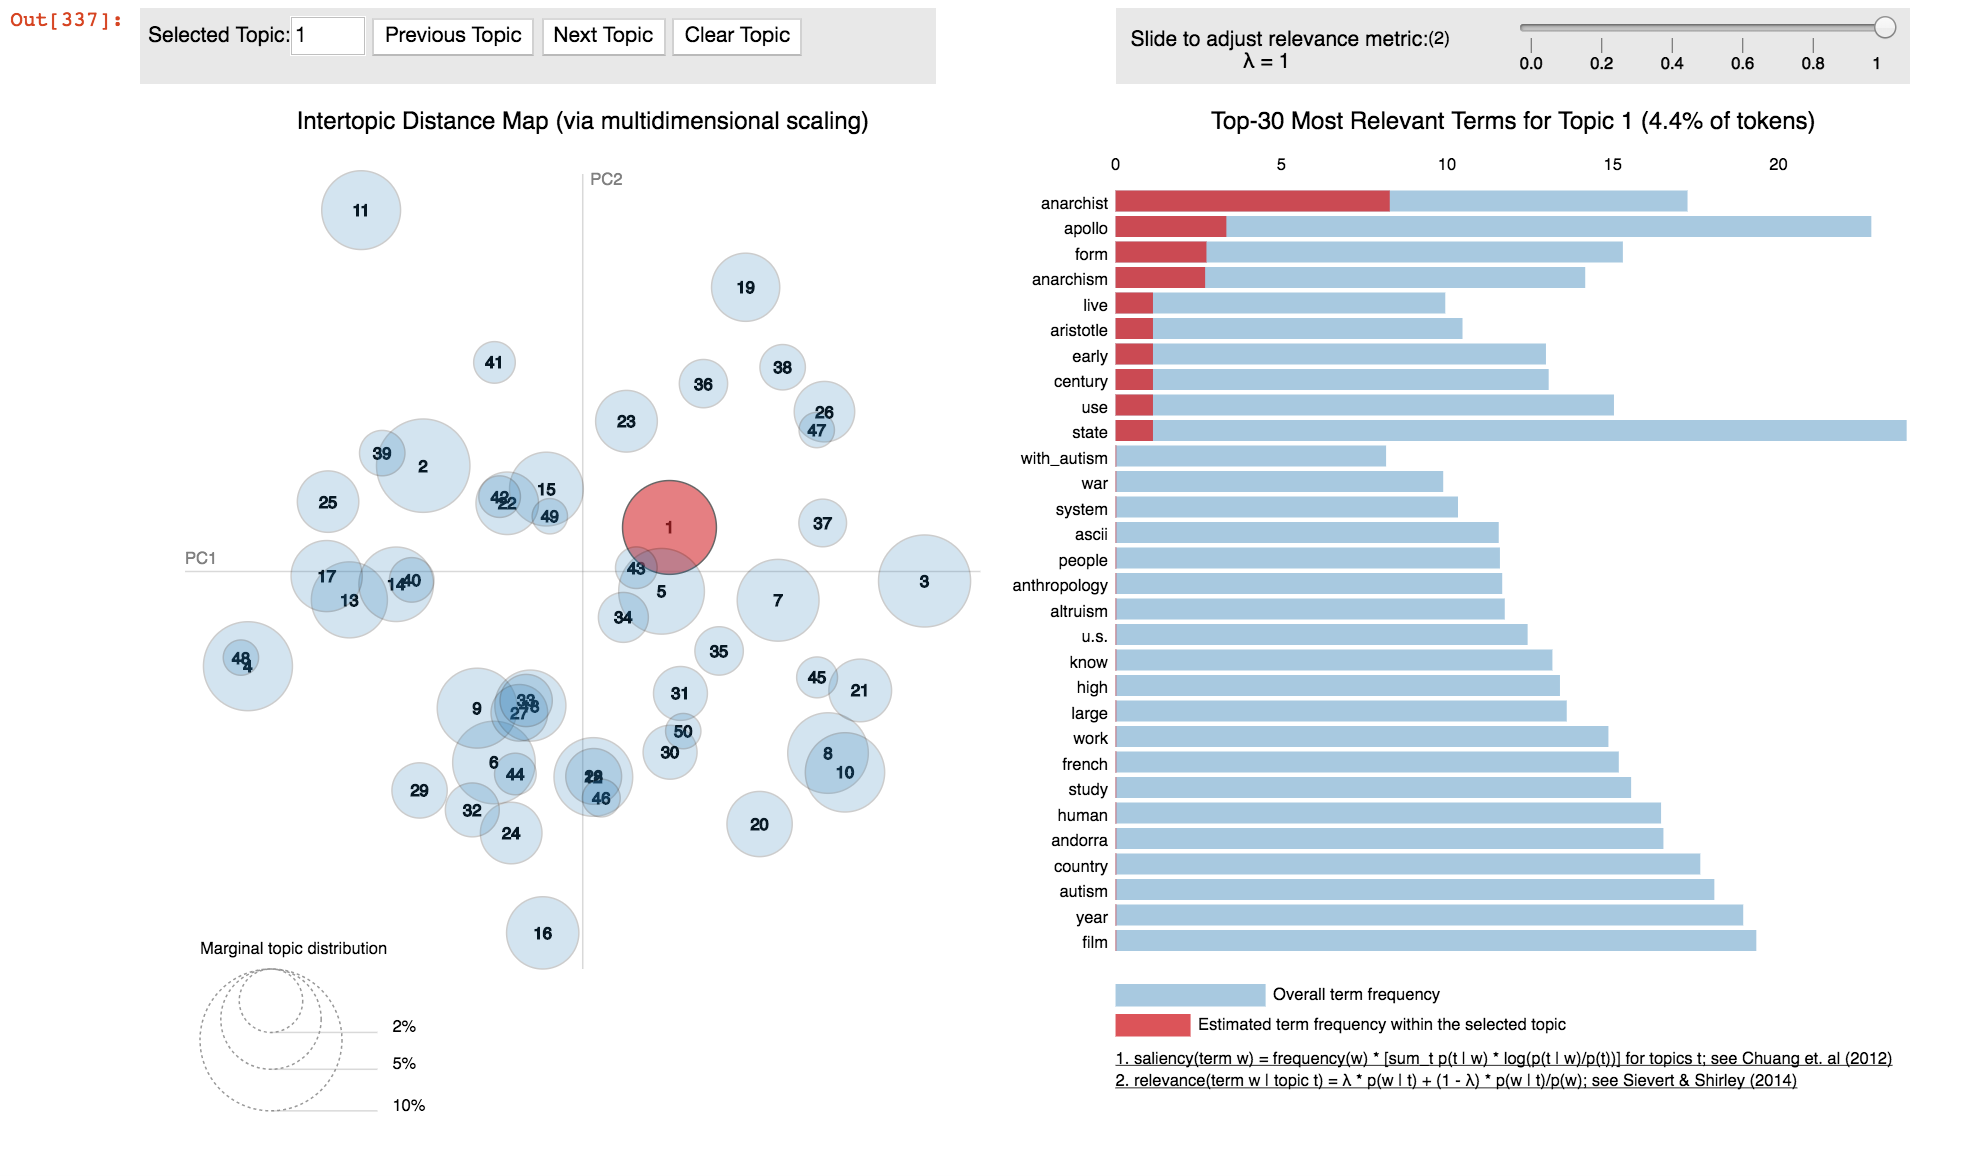

In [477]:
Image("img/pyLDAvis.png")


## Trying topic for each sentence

In [351]:
def f_topic_for_each(in_sentence):
    FE_sent_filepath=os.path.join(out_dir, 'tmp_FE_sent.txt')
    FE_trigram_dictionary_filepath = os.path.join(out_dir, 'tmp_FE_trigram_dict_all.dict')
    FE_trigram_bow_filepath = os.path.join(out_dir,
                                    'tmp_FE_trigram_bow_corpus_all.mm')
    FE_lda_model_filepath = os.path.join(out_dir, 'tmp_FE_lda_model_all')

    
    with open(FE_sent_filepath, 'w') as f:
        f.write(in_sentence)
    trigram_reviews = LineSentence(FE_sent_filepath)
    # learn the dictionary by iterating over all of the reviews
    trigram_dictionary = Dictionary(trigram_reviews)
    # filter tokens that are very rare or too common from
    # the dictionary (filter_extremes) and reassign integer ids (compactify)
    trigram_dictionary.filter_extremes(no_below=2, no_above=0.4)
    trigram_dictionary.compactify()
    trigram_dictionary.save(FE_trigram_dictionary_filepath)
    # load the finished dictionary from disk
    trigram_dictionary = Dictionary.load(FE_trigram_dictionary_filepath)

    # generate bag-of-words representations for
    # all reviews and save them as a matrix
    MmCorpus.serialize(FE_trigram_bow_filepath,
               trigram_bow_generator(FE_sent_filepath))

    # load the finished bag-of-words corpus from disk
    trigram_bow_corpus = MmCorpus(FE_trigram_bow_filepath)

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaMulticore(trigram_bow_corpus,
                           num_topics=50,
                           id2word=trigram_dictionary,
                           workers=1)

    lda.save(lda_model_filepath)

    # load the finished LDA model from disk
    lda = LdaMulticore.load(lda_model_filepath) 
    
    explore_topic(topic_number=0)


In [365]:
df_qid_context['context_raw'].head(1)

0    The earliest anarchist themes can be found in ...
Name: context_raw, dtype: object

In [383]:
var1=df_qid_context['context_trigram_nostopwords'].head(1).to_string(header=False, index=False)

In [423]:
df_temp=pd.DataFrame()
df_temp['context_trigram_nostopwords']=df_qid_context['context_trigram_nostopwords'].head(1)

In [426]:
df_temp.to_clipboard()

In [425]:
df_temp

,context_trigram_nostopwords
0,early anarchist theme find 6th century bc work...


In [ ]:
f_topic_for_each(var1)

In [401]:
FE_sent_filepath=os.path.join(out_dir, 'tmp_FE_sent.txt')
FE_trigram_dictionary_filepath = os.path.join(out_dir, 'tmp_FE_trigram_dict_all.dict')
FE_trigram_bow_filepath = os.path.join(out_dir,
                                'tmp_FE_trigram_bow_corpus_all.mm')
FE_lda_model_filepath = os.path.join(out_dir, 'tmp_FE_lda_model_all')


In [429]:
df_temp['context_trigram_nostopwords'].to_csv(FE_sent_filepath, header=False, index=False)

In [447]:
for item in trigram_dictionary.items():
    print(item)

In [458]:
trigram_dictionary.keys()

[]

In [459]:
trigram_reviews = LineSentence(FE_sent_filepath)
# learn the dictionary by iterating over all of the reviews
trigram_dictionary = Dictionary(trigram_reviews)
# filter tokens that are very rare or too common from
# the dictionary (filter_extremes) and reassign integer ids (compactify)
#TODO: trigram_dictionary.filter_extremes is resulting in zero records
#trigram_dictionary.filter_extremes(keep_n=5)
trigram_dictionary.compactify()
trigram_dictionary.save(FE_trigram_dictionary_filepath)
# load the finished dictionary from disk
trigram_dictionary = Dictionary.load(FE_trigram_dictionary_filepath)


In [461]:
# generate bag-of-words representations for
# all reviews and save them as a matrix
MmCorpus.serialize(FE_trigram_bow_filepath,
           trigram_bow_generator(FE_sent_filepath))

# load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(FE_trigram_bow_filepath)



In [462]:
trigram_bow_corpus.input

'./output/tmp_FE_trigram_bow_corpus_all.mm'

In [466]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    # workers => sets the parallelism, and should be
    # set to your number of physical cores minus one
    lda = LdaMulticore(trigram_bow_corpus,
                       num_topics=50,
                       id2word=trigram_dictionary)

lda.save(FE_lda_model_filepath)

# load the finished LDA model from disk
lda = LdaMulticore.load(FE_lda_model_filepath) 



In [474]:
explore_topic(topic_number=0)


term                 frequency

6th                  0.067
anarchist            0.067
bao                  0.067
bc                   0.067
century              0.067
early                0.067
find                 0.067
jingyan              0.067
laozi                0.067
later                0.067
philosopher          0.067
taoist               0.067
theme                0.067
work                 0.067
zhuangzi             0.067


In [475]:
explore_topic(topic_number=1)


term                 frequency

6th                  0.067
anarchist            0.067
bao                  0.067
bc                   0.067
century              0.067
early                0.067
find                 0.067
jingyan              0.067
laozi                0.067
later                0.067
philosopher          0.067
taoist               0.067
theme                0.067
work                 0.067
zhuangzi             0.067


In [470]:
LDAvis_data_filepath = os.path.join(out_dir, 'temp_FE_ldavis_prepared')
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus,
                                          trigram_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)



/Users/sdatta/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [471]:
pyLDAvis.display(LDAvis_prepared)


TypeError: Object of type complex is not JSON serializable